# Weeg Content Type Classifier – Model Training

This notebook trains a content-type classification model used in the Weeg Hive Platform to optimize web content delivery in bandwidth-constrained environments. It classifies websites into categories like news, blog, education, etc., using structural and semantic features.

Steps include:
- Loading and preprocessing data
- Extracting HTML and textual features
- Applying TF-IDF and Sentence-BERT
- Training a Random Forest with class balancing (SMOTE)
- Evaluating and visualizing model performance

### Import Libraries and Tools

We import all required libraries, including `scikit-learn`, `Goose3` for content extraction, `BeautifulSoup` for HTML parsing, `sentence-transformers` for semantic embeddings, and `imblearn` for class balancing.

In [4]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
from tqdm import tqdm
from goose3 import Goose
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import hstack
from sentence_transformers import SentenceTransformer
from imblearn.over_sampling import SMOTE
import pickle
import os

/Users/davicoscarelli/.matplotlib is not a writable directory
Matplotlib created a temporary cache directory at /var/folders/z3/ptrv6c7n0gl5f1pgzb7w2m340000gn/T/matplotlib-dda33b0w because there was an issue with the default path (/Users/davicoscarelli/.matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


### Fetch HTML Content and Metadata from URLs

We use Goose3 to extract metadata (title, description, keywords, etc.) and raw HTML from a list of websites. This forms the core input for our content classifier. Invalid or unreachable URLs are skipped.

In [2]:
# Load the dataset
file_path = 'data/website_classification.csv'
website_data = pd.read_csv(file_path)

# Initialize Goose
g = Goose()

# Function to fetch HTML content and metadata
def fetch_website_data(url):
    try:
        # Use Goose to extract additional information
        article = g.extract(url=url)
        if not article:
            return None

        # Gather metadata and other info
        info = article.infos
        metadata = {
            'title': info.get('title'),
            'description': info.get('meta', {}).get('description'),
            'lang': info.get('meta', {}).get('lang'),
            'keywords': info.get('meta', {}).get('keywords'),
            'favicon': info.get('meta', {}).get('favicon'),
            'canonical': info.get('meta', {}).get('canonical'),
            'encoding': info.get('meta', {}).get('encoding'),
            'domain': info.get('domain'),
            'image': info.get('image'),
            'cleaned_text': info.get('cleaned_text'),
            'authors': info.get('authors'),
            'publish_date': info.get('publish_date')
        }

        # Additionally, fetch raw HTML content
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        metadata['html_content'] = response.text

        return metadata
    except Exception as e:
        return None

# Create a new list to store data with successfully fetched HTML content and layout categories
html_data = []

# Iterate through the DataFrame with a progress bar
for _, row in tqdm(website_data.iterrows(), total=len(website_data), desc="Processing websites"):
    url = row['website_url']
    category = row['Category']

    # Fetch website data using Goose
    website_data = fetch_website_data(url)

    if website_data:
      layout_type = category
      # Append only successfully fetched data
      website_data.update({
            'website_url': url,
            'category': category,
            'layout_type': layout_type
        })
      html_data.append(website_data)

    # Pause to avoid overloading the server
    time.sleep(0.5)

# Convert the results into a DataFrame
html_df = pd.DataFrame(html_data)


Processing websites:  60%|█████▉    | 844/1408 [55:44<23:53,  2.54s/it]  Parser lxml failed to parse the content
Parser soup failed to parse the content
Processing websites:  61%|██████    | 856/1408 [56:26<26:44,  2.91s/it]Parser lxml failed to parse the content
Parser soup failed to parse the content
Processing websites:  76%|███████▋  | 1074/1408 [1:09:41<36:39,  6.59s/it]Parser lxml failed to parse the content
Parser soup failed to parse the content
Processing websites:  77%|███████▋  | 1090/1408 [1:10:31<16:41,  3.15s/it]Parser lxml failed to parse the content
Parser soup failed to parse the content
Processing websites:  86%|████████▌ | 1212/1408 [1:20:34<11:57,  3.66s/it]  Parser lxml failed to parse the content
Parser soup failed to parse the content
Processing websites:  94%|█████████▍| 1326/1408 [1:27:53<06:09,  4.51s/it]Parser lxml failed to parse the content
Parser soup failed to parse the content
Processing websites:  98%|█████████▊| 1383/1408 [1:31:01<00:44,  1.79s/it]Pars

### Save Extracted Website Data

After successful extraction, let's preview and save the data (including raw HTML and metadata) for later reuse in training.

In [3]:
html_df.head()

,title,description,lang,keywords,favicon,canonical,encoding,domain,image,cleaned_text,authors,publish_date,html_content,website_url,category,layout_type
0,"Booking.com | Official site | The best hotels,...",Explore the world with Booking.com. Big saving...,en,"lodging, accommodation, Hotel, Hotels, special...",https://cf.bstatic.com/static/img/favicon/9ca8...,https://www.booking.com/index.en-gb.html,utf-8,www.booking.com,None,\n• The only way to leave a review is to first...,[],None,<!DOCTYPE html>\n<!--\nYou know you could be g...,https://www.booking.com/index.html?aid=1743217,Travel,Travel
1,Expedia - Travel Sites - Best Travel Sites Lis...,Expedia.com is one of the most popular and wel...,en,,https://travelsites.com/wp-content/themes/trav...,https://travelsites.com/expedia/,utf-8,travelsites.com,None,We could all use a vacation now and then. You ...,[],None,"<!DOCTYPE html><html xmlns=""http://www.w3.org/...",https://travelsites.com/expedia/,Travel,Travel
2,TripAdvisor - Travel Sites - Best Travel Sites...,TripAdvisor is one of the most widely used hot...,en,,https://travelsites.com/wp-content/themes/trav...,https://travelsites.com/tripadvisor/,utf-8,travelsites.com,None,Is TripAdvisor Legit? Is it safe to book with ...,[],None,"<!DOCTYPE html><html xmlns=""http://www.w3.org/...",https://travelsites.com/tripadvisor/,Travel,Travel
3,Cheap Flights: Compare Flights & Flight Tickets,momondo searches hundreds of other travel site...,en,,/favicon.ico,https://www.momondo.in,None,www.momondo.in,None,We search and compare billions of real-time pr...,[],None,<!DOCTYPE html>\n<html lang='en-in' dir='ltr'>...,https://www.momondo.in/?ispredir=true,Travel,Travel
4,ebookers UK is ending,We have made the difficult decision to retire ...,en,,/favicon.ico,https://www.ebookers.com/ebookers-uk-ending,utf-8,www.ebookers.com,None,We have made the decision to retire ebookers a...,[],None,"<!DOCTYPE html><html data-language=""en_GB"" dir...",https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,Travel,Travel


In [4]:
html_df.to_csv('data/website_metadata_content.csv', index=False, escapechar='\\')

### HTML Feature Engineering

This function counts occurrences of specific HTML tags (like `<div>`, `<img>`, `<form>`) and computes the text-to-HTML length ratio to capture content density and structure.

In [5]:
# Load dataset
html_df = pd.read_csv('data/website_metadata_content.csv')

# Define HTML tags for feature extraction
tags = ['div', 'p', 'a', 'button', 'input', 'form', 'img', 'li', 'ul', 'ol', 'h1', 'h2', 'h3', 'section', 'article', 'header', 'footer', 'nav', 'video', 'audio', 'canvas']

# Function to extract HTML tag features
def extract_html_features(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    tag_counts = {tag: len(soup.find_all(tag)) for tag in tags}
    text_length = len(soup.get_text())
    html_length = len(html_content)
    text_html_ratio = text_length / html_length if html_length else 0
    features = list(tag_counts.values()) + [text_html_ratio]
    return features

### Extract Structural Features from HTML Content

We apply the tag-count extraction function across all rows. For missing HTML, we fallback to zeroed features.

In [6]:
# Apply feature extraction with a progress bar
print("Extracting HTML features...")
html_features = [
    extract_html_features(x) if pd.notnull(x) else [0] * (len(tags) + 1)
    for x in tqdm(html_df['html_content'], desc="Processing HTML content")
]

# Convert extracted features to a DataFrame
html_features_df = pd.DataFrame(html_features, columns=[f'{tag}_count' for tag in tags] + ['text_html_ratio'])
processed_df = pd.concat([html_df, html_features_df], axis=1)


Extracting HTML features...


Processing HTML content: 100%|██████████| 956/956 [00:15<00:00, 62.22it/s] 


### Extract Text Features with TF-IDF

We vectorize textual metadata fields (`title`, `description`, `keywords`, and `cleaned_text`) using TF-IDF to capture informative terms for classification.

In [7]:
# TF-IDF Vectorization for Text Fields
text_fields = ['title', 'description', 'cleaned_text', 'keywords']
tfidf_vectorizers = {}
text_vectors = []

print("Vectorizing text fields with TF-IDF...")
for field in text_fields:
    vectorizer = TfidfVectorizer(max_features=500)
    tfidf_matrix = vectorizer.fit_transform(processed_df[field].fillna(''))
    tfidf_vectorizers[field] = vectorizer
    text_vectors.append(tfidf_matrix)

# Combine TF-IDF vectors horizontally
combined_text_vectors = hstack(text_vectors)

Vectorizing text fields with TF-IDF...


### Generate Semantic Embeddings with Sentence-BERT

We use `all-MiniLM-L6-v2` from `sentence-transformers` to generate sentence-level embeddings for titles and descriptions, capturing semantic similarities across content types.

In [8]:
# Domain-specific NLP embeddings with Sentence-BERT for titles and descriptions
print("Generating embeddings with Sentence-BERT...")
model = SentenceTransformer('all-MiniLM-L6-v2')
title_embeddings = model.encode(processed_df['title'].fillna(''), show_progress_bar=True)
description_embeddings = model.encode(processed_df['description'].fillna(''), show_progress_bar=True)

Generating embeddings with Sentence-BERT...


Batches:   0%|          | 0/30 [00:00<?, ?it/s]

Batches:   0%|          | 0/30 [00:00<?, ?it/s]

### Combine All Features

We merge all numerical, textual, and semantic features into a single sparse matrix `X` for model training.

In [9]:
# Stack HTML features, TF-IDF, and embeddings together
html_numerical_features = processed_df[[f'{tag}_count' for tag in tags] + ['text_html_ratio']].values
X = hstack([combined_text_vectors, html_numerical_features, title_embeddings, description_embeddings])

### Encode Labels and Balance Classes

Category labels are numerically encoded, and class imbalance is handled using SMOTE (Synthetic Minority Over-sampling Technique).

In [10]:
# Encode target labels
y = processed_df['category']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Use SMOTE for class balancing
print("Applying SMOTE for balancing classes...")
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

Applying SMOTE for balancing classes...


### Split Dataset into Training and Testing

We use an 80/20 split to evaluate performance on unseen data.

In [11]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

### Train Random Forest with Hyperparameter Tuning

We use GridSearchCV to tune Random Forest parameters with 5-fold cross-validation, optimizing for classification accuracy.

In [12]:
# Initialize RandomForest model and perform grid search
print("Hyperparameter tuning with GridSearchCV for Random Forest...")
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [20, 30, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Use the best model found
best_rf_model = grid_search.best_estimator_

Hyperparameter tuning with GridSearchCV for Random Forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.7s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.9s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.0s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.1s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.1s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   4.5s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   4.6s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   4.8s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.8s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total tim

### Evaluate Best Model via Cross-Validation

We assess the best Random Forest model using 5-fold cross-validation across multiple metrics (accuracy, precision, recall, F1).

In [13]:
# Cross-validation for the best model
print("\nCross-validation for the best Random Forest model...")
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
cv_results = cross_validate(best_rf_model, X_train, y_train, cv=5, scoring=scoring, return_train_score=True)

# Display cross-validation results
print("\nCross-Validation Results:")
for metric in scoring:
    print(f"{metric.capitalize()}:")
    print(f" - Mean: {np.mean(cv_results['test_' + metric]):.4f}")
    print(f" - Std Dev: {np.std(cv_results['test_' + metric]):.4f}")



Cross-validation for the best Random Forest model...

Cross-Validation Results:
Accuracy:
 - Mean: 0.8134
 - Std Dev: 0.0268
Precision_weighted:
 - Mean: 0.8287
 - Std Dev: 0.0230
Recall_weighted:
 - Mean: 0.8134
 - Std Dev: 0.0268
F1_weighted:
 - Mean: 0.8137
 - Std Dev: 0.0269


The model performs consistently well across metrics with ~81–83% on average. Low variance across folds indicates robustness across different data splits.

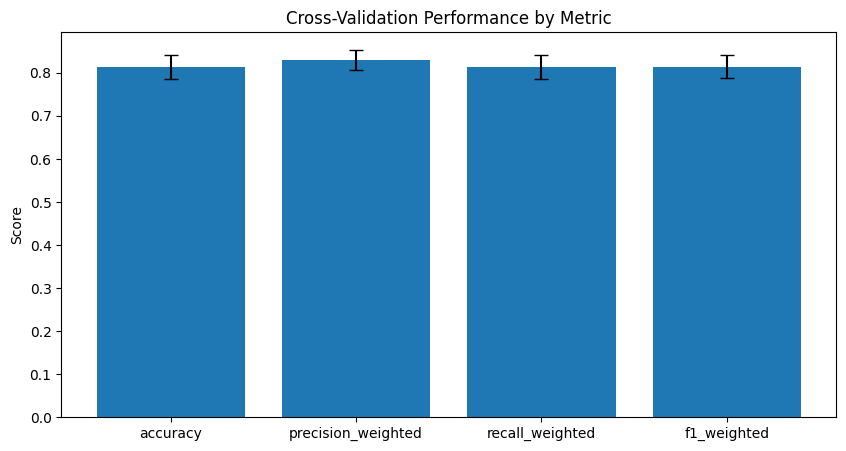

In [14]:
# Visualization of cross-validation results
plt.figure(figsize=(10, 5))
plt.bar(scoring, [np.mean(cv_results['test_' + metric]) for metric in scoring],
        yerr=[np.std(cv_results['test_' + metric]) for metric in scoring], capsize=5)
plt.title("Cross-Validation Performance by Metric")
plt.ylabel("Score")
plt.show()


### Evaluate on Test Set

We retrain the model on the full training set and evaluate it on the test set. Accuracy and a full classification report are printed.

In [15]:
# Train and evaluate on the test set
print("\nTraining the final model on the full training set...")
best_rf_model.fit(X_train, y_train)
y_pred = best_rf_model.predict(X_test)

# Test accuracy and detailed classification report
test_accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Set Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))



Training the final model on the full training set...

Test Set Accuracy: 0.8419

Classification Report:
                                 precision    recall  f1-score   support

                          Adult       1.00      1.00      1.00        12
             Business/Corporate       0.57      0.63      0.60        19
       Computers and Technology       0.76      0.81      0.79        16
                     E-Commerce       0.79      0.65      0.71        17
                      Education       0.52      0.75      0.62        16
                           Food       0.90      0.82      0.86        22
                         Forums       1.00      1.00      1.00        17
                          Games       0.93      0.82      0.88        17
             Health and Fitness       0.83      0.83      0.83        12
             Law and Government       0.95      0.95      0.95        20
                           News       0.94      0.89      0.92        19
                  

The model achieves 84.2% accuracy on the test set. Most categories are well-separated, though minor confusion appears between related classes (e.g., Business vs. E-Commerce, Education vs. Blog).

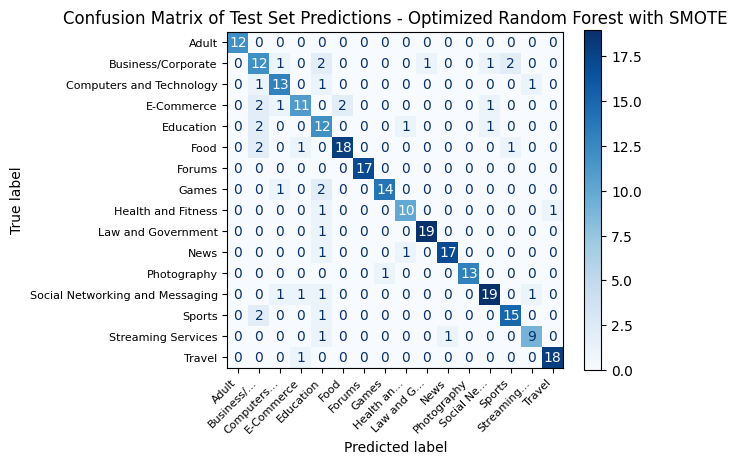

In [16]:
# Visualize Confusion Matrix

def truncate_labels(labels, max_len=12):
    return [label if len(label) <= max_len else label[:max_len-3] + "..." for label in labels]

full_labels = label_encoder.classes_
truncated_x_labels = truncate_labels(full_labels, max_len=12)

disp = ConfusionMatrixDisplay.from_estimator(
    best_rf_model,
    X_test,
    y_test,
    display_labels=full_labels,  
    cmap="Blues"
)

ax = disp.ax_
ax.set_xticks(range(len(truncated_x_labels)))
ax.set_xticklabels(truncated_x_labels, rotation=45, ha='right', fontsize=8)
ax.set_yticklabels(full_labels, fontsize=8)

plt.title("Confusion Matrix of Test Set Predictions - Optimized Random Forest with SMOTE")
plt.tight_layout()
plt.show()

### Save Model and Artifacts

We serialize the trained Random Forest model, label encoder, TF-IDF vectorizers, and Sentence-BERT model name to disk for later use in the Weeg content pipeline.

In [17]:
os.makedirs('models', exist_ok=True)

# Paths to save model and artifacts
model_path = 'models/random_forest_model.pkl'
label_encoder_path = 'models/label_encoder.pkl'
tfidf_vectorizers_path = 'models/tfidf_vectorizers.pkl'
sentence_bert_model_path = 'models/sentence_bert_model.pkl'

# Save RandomForest model
with open(model_path, 'wb') as model_file:
    pickle.dump(best_rf_model, model_file)

# Save Label Encoder
with open(label_encoder_path, 'wb') as le_file:
    pickle.dump(label_encoder, le_file)

# Save TF-IDF vectorizers
with open(tfidf_vectorizers_path, 'wb') as tfidf_file:
    pickle.dump(tfidf_vectorizers, tfidf_file)

# Save Sentence-BERT model (though typically, it's reloaded directly by its name)
sentence_bert_model_name = 'all-MiniLM-L6-v2'
print(f"Model and artifacts saved successfully. For Sentence-BERT, use model name '{sentence_bert_model_name}' to load it.")


Model and artifacts saved successfully. For Sentence-BERT, use model name 'all-MiniLM-L6-v2' to load it.
